<a href="https://colab.research.google.com/github/maxmatical/fast.ai/blob/master/imagewang_03_train_supervised_teacher_model_and_generate_SOFT_pseudolabels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%%capture
!pip install --upgrade fastai

# Notes:

possible changes to training regime 

1. in addition to predicting soft labels for unlabelled images, would it be useful to predict soft-pseudolabels for training data as well?

2. training only on soft labels for unlabelled images, then finetune on train+val data (doesn't seem ideal according to noisy student paper)

# Train initial model

In [3]:
import pandas as pd
from fastai.vision.all import *
from fastai.test_utils import show_install
show_install()



```text
=== Software === 
python        : 3.7.10
fastai        : 2.3.1
fastcore      : 1.3.20
fastprogress  : 0.2.7
torch         : 1.8.1+cu101
nvidia driver : 460.32
torch cuda    : 10.1 / is available
torch cudnn   : 7603 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : Tesla P4

=== Environment === 
platform      : Linux-5.4.109+-x86_64-with-Ubuntu-18.04-bionic
distro        : #1 SMP Tue Apr 20 19:55:43 PDT 2021
conda env     : Unknown
python        : /usr/bin/python3
sys.path      : 
/content
/env/python
/usr/lib/python37.zip
/usr/lib/python3.7
/usr/lib/python3.7/lib-dynload
/usr/local/lib/python3.7/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.7/dist-packages/IPython/extensions
/root/.ipython
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional package(s) to enhance the diagnostics can be installed with:
pip install distro
On

In [4]:
path = untar_data(URLs.IMAGEWANG)
path.ls()

(#4) [Path('/root/.fastai/data/imagewang/unsup'),Path('/root/.fastai/data/imagewang/models'),Path('/root/.fastai/data/imagewang/val'),Path('/root/.fastai/data/imagewang/train')]

In [5]:
%ls '/root/.fastai/data/imagewang/train'

n01440764/  n02089973/  n02102040/  n02979186/  n03417042/
n02086240/  n02093754/  n02105641/  n03000684/  n03425413/
n02087394/  n02096294/  n02111889/  n03028079/  n03445777/
n02088364/  n02099601/  n02115641/  n03394916/  n03888257/


creating dataloader from folder

In [ ]:
# defining batch and individual image transforms
size = 224
tfms = aug_transforms(size=size, max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1.)
item_tfms = RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.)) # used to get images all the same size

# batch transforms
batch_tfms = [*tfms, Normalize.from_stats(*imagenet_stats)]

# creating dataloader
dl = ImageDataLoaders.from_folder(path, train="train", valid="val", batch_tfms=batch_tfms, item_tfms=item_tfms, bs=64)


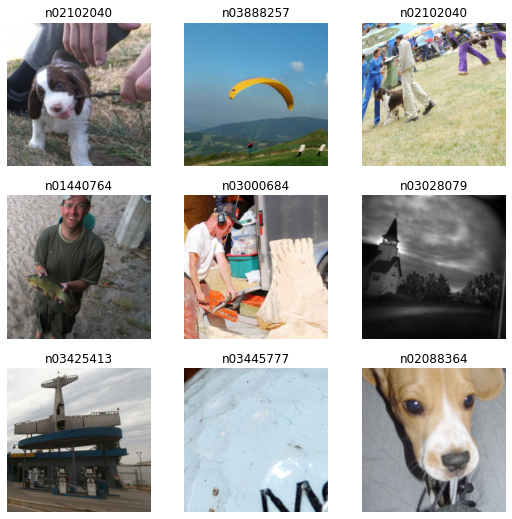

In [ ]:
dl.show_batch()

In [ ]:
dl.vocab

['n01440764', 'n02086240', 'n02087394', 'n02088364', 'n02089973', 'n02093754', 'n02096294', 'n02099601', 'n02102040', 'n02105641', 'n02111889', 'n02115641', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']

In [ ]:
dl.vocab.o2i

{'n01440764': 0,
 'n02086240': 1,
 'n02087394': 2,
 'n02088364': 3,
 'n02089973': 4,
 'n02093754': 5,
 'n02096294': 6,
 'n02099601': 7,
 'n02102040': 8,
 'n02105641': 9,
 'n02111889': 10,
 'n02115641': 11,
 'n02979186': 12,
 'n03000684': 13,
 'n03028079': 14,
 'n03394916': 15,
 'n03417042': 16,
 'n03425413': 17,
 'n03445777': 18,
 'n03888257': 19}

## creating learner

In [21]:
# need to use this to get rid of a typeerror in learner
def get_model(model, pretrained=False, **kwargs):
    """model: function to load the model, e.g. resnet18
        pretrained, progress: to be passed to the model function
    """
    m = model(pretrained=pretrained, **kwargs) # loads standard model

    return m


In [ ]:
# hyperparameters for ranger

# optional: use the ranger library
sqrmom=0.99
mom=0.95
beta=0.
eps=1e-4
opt_func = partial(ranger, mom=mom, sqr_mom=sqrmom, eps=eps, beta=beta)

# use no pretrained weights
# use xresnet instead of standard resnet
learn = cnn_learner(dl, 
                    partial(get_model, model=xresnet18, pretrained=False),
                    metrics=accuracy,
                    loss_func=LabelSmoothingCrossEntropy(), 
                    opt_func=opt_func).to_fp16()



Downloading: "https://s3.amazonaws.com/fast-ai-modelzoo/xrn50_940.pth" to /root/.cache/torch/hub/checkpoints/xrn50_940.pth


In [ ]:
learn.unfreeze();

# learn.summary()


train from scratch

SuggestedLRs(lr_min=0.02089296132326126, lr_steep=0.010964781977236271)

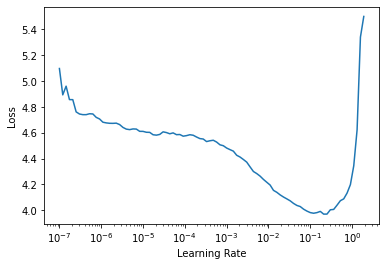

In [ ]:
# learn.lr_find()

In [ ]:
# callbacks
# reduce lr on plateau has lower patience than early stopping so model gets a chance to improve before stopping training
use_mixup = True
model_fname = "/content/drive/MyDrive/imagewang_tests_soft_pseudolabels/model_01"

cbs = [
    ReduceLROnPlateau(monitor='accuracy',factor=5,patience=3),
    EarlyStoppingCallback(monitor='accuracy', min_delta=0.01, patience=4),
    SaveModelCallback(monitor="accuracy", fname=model_fname)
]
if use_mixup:
    cbs.append(MixUp(0.4))
print(cbs)

[ReduceLROnPlateau, EarlyStoppingCallback, SaveModelCallback, MixUp]


In [ ]:
lr = 0.02
pct_start = 0.3
learn.fit_flat_cos(20, lr=lr, pct_start=pct_start, cbs=cbs)


epoch,train_loss,valid_loss,accuracy,time
0,2.375650,4.068278,0.002291,03:00
1,2.033265,3.619538,0.012217,02:59
2,1.903531,3.513602,0.006363,02:59
3,1.818926,3.443517,0.012726,02:58
4,1.785730,3.450950,0.016035,02:58
5,1.748842,3.017889,0.114024,02:58
6,1.717838,2.938171,0.127259,02:59
7,1.667560,2.819420,0.151438,02:58
8,1.635552,2.516009,0.261899,02:59
9,1.611466,2.351091,0.301603,03:00


Better model found at epoch 0 with accuracy value: 0.0022906591184437275.
Better model found at epoch 1 with accuracy value: 0.012216849252581596.
Better model found at epoch 3 with accuracy value: 0.012725884094834328.
Better model found at epoch 4 with accuracy value: 0.01603461429476738.
Better model found at epoch 5 with accuracy value: 0.11402392387390137.
Better model found at epoch 6 with accuracy value: 0.12725883722305298.
Better model found at epoch 7 with accuracy value: 0.15143802762031555.
Better model found at epoch 8 with accuracy value: 0.2618986964225769.
Better model found at epoch 9 with accuracy value: 0.3016034662723541.
Better model found at epoch 11 with accuracy value: 0.39501145482063293.
Better model found at epoch 12 with accuracy value: 0.4665309190750122.
Better model found at epoch 14 with accuracy value: 0.47365742921829224.
Better model found at epoch 15 with accuracy value: 0.5265970826148987.
Better model found at epoch 17 with accuracy value: 0.540595

## Results
Got accuracy of around `0.5495036840438843`

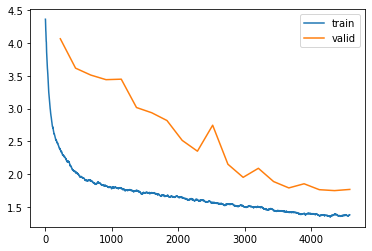

In [ ]:
learn.recorder.plot_loss()

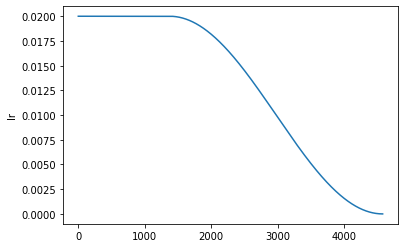

In [ ]:
learn.recorder.plot_sched()

## predict pseudo-labels

predict with `get_preds`

do we need to make sure it's ordered? (doesn't seem like its needed)

In [ ]:
path

Path('/root/.fastai/data/imagewang')

In [ ]:
test_imgs = get_image_files(f"{path}/unsup")
dl_test = learn.dls.test_dl(test_imgs)

In [ ]:
# def noop(x):
#     return x

In [ ]:
res = learn.get_preds(dl=dl_test, with_decoded=True, act=noop)

In [ ]:
len(res)

3

`res` is a tuple of length 3 (2 if `with_decoded = False`)

`res[0]` is the raw logits -> a tensor with shape `[n, k]`

`res[1]` is the input labels, will be empty if labels not provided

`res[2]` is the decoded input labels, is a 1d tensor with shape `[n, 1]`

In [ ]:
res[0].shape

torch.Size([7750, 20])

In [ ]:
pred_proba = res[0].cpu().numpy()

In [ ]:
pred_proba

array([[-1.6455078 ,  1.7041016 , -1.7314453 , ..., -0.2722168 ,
         0.32983398, -1.0634766 ],
       [ 0.9355469 , -0.51660156,  0.56103516, ..., -1.5546875 ,
        -0.69677734, -2.2851562 ],
       [-0.6020508 , -1.0478516 ,  3.4941406 , ..., -1.6826172 ,
        -0.6958008 , -0.63378906],
       ...,
       [-0.7373047 ,  3.28125   , -0.8613281 , ..., -1.0234375 ,
        -0.67285156,  0.19470215],
       [-0.5678711 ,  0.4650879 ,  1.2568359 , ..., -0.7866211 ,
        -0.57910156, -0.03720093],
       [-1.1884766 ,  3.8359375 , -1.5927734 , ..., -0.6333008 ,
        -0.39233398, -1.2480469 ]], dtype=float32)

In [ ]:
# convert back into original labels
i2o = {v:k for k,v in dl.vocab.o2i.items()}
i2o

{0: 'n01440764',
 1: 'n02086240',
 2: 'n02087394',
 3: 'n02088364',
 4: 'n02089973',
 5: 'n02093754',
 6: 'n02096294',
 7: 'n02099601',
 8: 'n02102040',
 9: 'n02105641',
 10: 'n02111889',
 11: 'n02115641',
 12: 'n02979186',
 13: 'n03000684',
 14: 'n03028079',
 15: 'n03394916',
 16: 'n03417042',
 17: 'n03425413',
 18: 'n03445777',
 19: 'n03888257'}

In [ ]:
classes = [v for k,v in i2o.items()]
classes
# pred_class_orig

['n01440764',
 'n02086240',
 'n02087394',
 'n02088364',
 'n02089973',
 'n02093754',
 'n02096294',
 'n02099601',
 'n02102040',
 'n02105641',
 'n02111889',
 'n02115641',
 'n02979186',
 'n03000684',
 'n03028079',
 'n03394916',
 'n03417042',
 'n03425413',
 'n03445777',
 'n03888257']

In [ ]:
df_pred_probas = pd.DataFrame(pred_proba, columns=classes)
df_pred_probas.head(5)

,n01440764,n02086240,n02087394,n02088364,n02089973,n02093754,n02096294,n02099601,n02102040,n02105641,n02111889,n02115641,n02979186,n03000684,n03028079,n03394916,n03417042,n03425413,n03445777,n03888257
0,-1.645508,1.704102,-1.731445,-0.502930,-0.861816,-0.235229,-1.244141,1.530273,1.318359,3.269531,4.089844,0.613281,-1.744141,-1.092773,-0.129639,-1.392578,-0.677734,-0.272217,0.329834,-1.063477
1,0.935547,-0.516602,0.561035,-0.276123,-0.817383,4.707031,2.564453,0.911621,-0.354492,-1.097656,-1.831055,1.657227,-0.694336,0.300537,0.048157,-1.811523,-2.050781,-1.554688,-0.696777,-2.285156
2,-0.602051,-1.047852,3.494141,-0.726562,-0.120300,0.218872,2.912109,4.753906,-1.947266,-2.146484,-0.664062,3.507812,-1.208984,-0.134644,-1.529297,-0.940918,-0.580566,-1.682617,-0.695801,-0.633789
3,0.469482,-2.160156,5.207031,0.151245,0.075378,-0.732422,-0.555176,1.132812,-1.209961,-2.357422,-1.317383,2.167969,-0.726562,-0.327393,-1.541016,0.890137,-1.823242,1.580078,0.311035,-0.496582
4,-1.152344,5.500000,-1.975586,-1.621094,-2.017578,0.990234,1.945312,3.195312,-0.322021,6.812500,3.904297,-1.278320,-2.896484,-3.388672,-0.226318,-2.078125,-0.407227,-2.353516,-0.612793,-0.155029


In [ ]:
test_img_files = [str(f) for f in test_imgs]
test_img_files[:5]

['/root/.fastai/data/imagewang/unsup/n02111889_15388.JPEG',
 '/root/.fastai/data/imagewang/unsup/n02093754_1597.JPEG',
 '/root/.fastai/data/imagewang/unsup/n02099601_6613.JPEG',
 '/root/.fastai/data/imagewang/unsup/n02087394_13733.JPEG',
 '/root/.fastai/data/imagewang/unsup/n02105641_13464.JPEG']

In [ ]:
df_unlabelled_images = pd.DataFrame({"fname": test_img_files})
df_unlabelled_images.head(5)

,fname
0,/root/.fastai/data/imagewang/unsup/n02111889_15388.JPEG
1,/root/.fastai/data/imagewang/unsup/n02093754_1597.JPEG
2,/root/.fastai/data/imagewang/unsup/n02099601_6613.JPEG
3,/root/.fastai/data/imagewang/unsup/n02087394_13733.JPEG
4,/root/.fastai/data/imagewang/unsup/n02105641_13464.JPEG


In [ ]:
df_pseudo_labels = pd.concat([df_unlabelled_images, df_pred_probas], axis=1)
df_pseudo_labels["is_valid"] = False
df_pseudo_labels.head(5)

,fname,n01440764,n02086240,n02087394,n02088364,n02089973,n02093754,n02096294,n02099601,n02102040,n02105641,n02111889,n02115641,n02979186,n03000684,n03028079,n03394916,n03417042,n03425413,n03445777,n03888257,is_valid
0,/root/.fastai/data/imagewang/unsup/n02111889_15388.JPEG,-1.645508,1.704102,-1.731445,-0.502930,-0.861816,-0.235229,-1.244141,1.530273,1.318359,3.269531,4.089844,0.613281,-1.744141,-1.092773,-0.129639,-1.392578,-0.677734,-0.272217,0.329834,-1.063477,False
1,/root/.fastai/data/imagewang/unsup/n02093754_1597.JPEG,0.935547,-0.516602,0.561035,-0.276123,-0.817383,4.707031,2.564453,0.911621,-0.354492,-1.097656,-1.831055,1.657227,-0.694336,0.300537,0.048157,-1.811523,-2.050781,-1.554688,-0.696777,-2.285156,False
2,/root/.fastai/data/imagewang/unsup/n02099601_6613.JPEG,-0.602051,-1.047852,3.494141,-0.726562,-0.120300,0.218872,2.912109,4.753906,-1.947266,-2.146484,-0.664062,3.507812,-1.208984,-0.134644,-1.529297,-0.940918,-0.580566,-1.682617,-0.695801,-0.633789,False
3,/root/.fastai/data/imagewang/unsup/n02087394_13733.JPEG,0.469482,-2.160156,5.207031,0.151245,0.075378,-0.732422,-0.555176,1.132812,-1.209961,-2.357422,-1.317383,2.167969,-0.726562,-0.327393,-1.541016,0.890137,-1.823242,1.580078,0.311035,-0.496582,False
4,/root/.fastai/data/imagewang/unsup/n02105641_13464.JPEG,-1.152344,5.500000,-1.975586,-1.621094,-2.017578,0.990234,1.945312,3.195312,-0.322021,6.812500,3.904297,-1.278320,-2.896484,-3.388672,-0.226318,-2.078125,-0.407227,-2.353516,-0.612793,-0.155029,False


create df_train and df_val too from path later, seems like it should be pretty straight forward

## saving model weights and df_pseudo_labels to google drive

In [ ]:
df_pseudo_labels.to_csv("/content/drive/MyDrive/imagewang_tests_soft_pseudolabels/pseudolabels_01.csv", index=False)

In [ ]:
!ls "/content/drive/MyDrive/imagewang_tests_soft_pseudolabels"

model_01.pth  pseudolabels_01.csv


# Train student model on pseudolabels

In [7]:
df_pseudo_labels = pd.read_csv("/content/drive/MyDrive/imagewang_tests_soft_pseudolabels/pseudolabels_01.csv")
df_pseudo_labels.head(5)

,fname,n01440764,n02086240,n02087394,n02088364,n02089973,n02093754,n02096294,n02099601,n02102040,n02105641,n02111889,n02115641,n02979186,n03000684,n03028079,n03394916,n03417042,n03425413,n03445777,n03888257,is_valid
0,/root/.fastai/data/imagewang/unsup/n02111889_15388.JPEG,-1.645508,1.704102,-1.731445,-0.502930,-0.861816,-0.235229,-1.244141,1.530273,1.318359,3.269531,4.089844,0.613281,-1.744141,-1.092773,-0.129639,-1.392578,-0.677734,-0.272217,0.329834,-1.063477,False
1,/root/.fastai/data/imagewang/unsup/n02093754_1597.JPEG,0.935547,-0.516602,0.561035,-0.276123,-0.817383,4.707031,2.564453,0.911621,-0.354492,-1.097656,-1.831055,1.657227,-0.694336,0.300537,0.048157,-1.811523,-2.050781,-1.554688,-0.696777,-2.285156,False
2,/root/.fastai/data/imagewang/unsup/n02099601_6613.JPEG,-0.602051,-1.047852,3.494141,-0.726562,-0.120300,0.218872,2.912109,4.753906,-1.947266,-2.146484,-0.664062,3.507812,-1.208984,-0.134644,-1.529297,-0.940918,-0.580566,-1.682617,-0.695801,-0.633789,False
3,/root/.fastai/data/imagewang/unsup/n02087394_13733.JPEG,0.469482,-2.160156,5.207031,0.151245,0.075378,-0.732422,-0.555176,1.132812,-1.209961,-2.357422,-1.317383,2.167969,-0.726562,-0.327393,-1.541016,0.890137,-1.823242,1.580078,0.311035,-0.496582,False
4,/root/.fastai/data/imagewang/unsup/n02105641_13464.JPEG,-1.152344,5.500000,-1.975586,-1.621094,-2.017578,0.990234,1.945312,3.195312,-0.322021,6.812500,3.904297,-1.278320,-2.896484,-3.388672,-0.226318,-2.078125,-0.407227,-2.353516,-0.612793,-0.155029,False


In [8]:
from pathlib import Path, PurePath

classes = ['n01440764',
 'n02086240',
 'n02087394',
 'n02088364',
 'n02089973',
 'n02093754',
 'n02096294',
 'n02099601',
 'n02102040',
 'n02105641',
 'n02111889',
 'n02115641',
 'n02979186',
 'n03000684',
 'n03028079',
 'n03394916',
 'n03417042',
 'n03425413',
 'n03445777',
 'n03888257']


## create train and val dfs from path

In [9]:
all_fnames = []
all_labels = []
for r, d, f in os.walk(f"{path}/train"):
    if not d:
        fnames = [f"{r}/{fname}" for fname in f]
        labels = [PurePath(fname).parent.name for fname in fnames]
        all_fnames.extend(fnames)
        all_labels.extend(labels)

is_valid = [False]* len(all_fnames)


df_train = pd.DataFrame({"fname":all_fnames, "class":all_labels, "is_valid":is_valid})
df_train.head(5)

,fname,class,is_valid
0,/root/.fastai/data/imagewang/train/n02111889/n02111889_2609.JPEG,n02111889,False
1,/root/.fastai/data/imagewang/train/n02111889/n02111889_1649.JPEG,n02111889,False
2,/root/.fastai/data/imagewang/train/n02111889/n02111889_1129.JPEG,n02111889,False
3,/root/.fastai/data/imagewang/train/n02111889/n02111889_8909.JPEG,n02111889,False
4,/root/.fastai/data/imagewang/train/n02111889/n02111889_11679.JPEG,n02111889,False


adding one hot encoded labels (hard labels)

In [10]:
df_train_onehot = pd.get_dummies(df_train["class"])
df_train_onehot.head(5)

,n01440764,n02086240,n02087394,n02088364,n02089973,n02093754,n02096294,n02099601,n02102040,n02105641,n02111889,n02115641,n02979186,n03000684,n03028079,n03394916,n03417042,n03425413,n03445777,n03888257
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [11]:
# check to make sure the order is the same as classes
df_train_onehot.columns.to_list() == classes

True

In [12]:
df_train_pseudolabels = pd.concat([df_train, df_train_onehot], axis=1).drop(columns=["class"])
df_train_pseudolabels.head(5)

,fname,is_valid,n01440764,n02086240,n02087394,n02088364,n02089973,n02093754,n02096294,n02099601,n02102040,n02105641,n02111889,n02115641,n02979186,n03000684,n03028079,n03394916,n03417042,n03425413,n03445777,n03888257
0,/root/.fastai/data/imagewang/train/n02111889/n02111889_2609.JPEG,False,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,/root/.fastai/data/imagewang/train/n02111889/n02111889_1649.JPEG,False,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,/root/.fastai/data/imagewang/train/n02111889/n02111889_1129.JPEG,False,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,/root/.fastai/data/imagewang/train/n02111889/n02111889_8909.JPEG,False,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,/root/.fastai/data/imagewang/train/n02111889/n02111889_11679.JPEG,False,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [13]:
all_fnames = []
all_labels = []
for r, d, f in os.walk(f"{path}/val"):
    if not d:
        fnames = [f"{r}/{fname}" for fname in f]
        labels = [PurePath(fname).parent.name for fname in fnames]
        all_fnames.extend(fnames)
        all_labels.extend(labels)

is_valid = [True]* len(all_fnames)


df_val = pd.DataFrame({"fname":all_fnames, "class":all_labels, "is_valid":is_valid})
df_val.head(5)

,fname,class,is_valid
0,/root/.fastai/data/imagewang/val/n02111889/n02111889_15472.JPEG,n02111889,True
1,/root/.fastai/data/imagewang/val/n02111889/n02111889_7100.JPEG,n02111889,True
2,/root/.fastai/data/imagewang/val/n02111889/n02111889_5072.JPEG,n02111889,True
3,/root/.fastai/data/imagewang/val/n02111889/n02111889_5791.JPEG,n02111889,True
4,/root/.fastai/data/imagewang/val/n02111889/n02111889_4142.JPEG,n02111889,True


In [14]:
df_val_onehot = pd.get_dummies(df_val["class"])
df_val_pseudolabels = pd.concat([df_val, df_val_onehot], axis=1).drop(columns=["class"])
df_val_pseudolabels.tail(5)

,fname,is_valid,n02086240,n02087394,n02088364,n02089973,n02093754,n02096294,n02099601,n02105641,n02111889,n02115641
3924,/root/.fastai/data/imagewang/val/n02086240/n02086240_9401.JPEG,True,1,0,0,0,0,0,0,0,0,0
3925,/root/.fastai/data/imagewang/val/n02086240/n02086240_30.JPEG,True,1,0,0,0,0,0,0,0,0,0
3926,/root/.fastai/data/imagewang/val/n02086240/n02086240_2870.JPEG,True,1,0,0,0,0,0,0,0,0,0
3927,/root/.fastai/data/imagewang/val/n02086240/n02086240_6032.JPEG,True,1,0,0,0,0,0,0,0,0,0
3928,/root/.fastai/data/imagewang/val/n02086240/n02086240_6010.JPEG,True,1,0,0,0,0,0,0,0,0,0


### combine all data together

In [15]:
df_data = pd.concat([df_train_pseudolabels, df_pseudo_labels, df_val_pseudolabels], axis=0)
# since df_val doesn't have all classes, turn nans to 0.0
df_data = df_data.fillna(0.0)

In [16]:
df_data.tail(5)

,fname,is_valid,n01440764,n02086240,n02087394,n02088364,n02089973,n02093754,n02096294,n02099601,n02102040,n02105641,n02111889,n02115641,n02979186,n03000684,n03028079,n03394916,n03417042,n03425413,n03445777,n03888257
3924,/root/.fastai/data/imagewang/val/n02086240/n02086240_9401.JPEG,True,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3925,/root/.fastai/data/imagewang/val/n02086240/n02086240_30.JPEG,True,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3926,/root/.fastai/data/imagewang/val/n02086240/n02086240_2870.JPEG,True,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3927,/root/.fastai/data/imagewang/val/n02086240/n02086240_6032.JPEG,True,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3928,/root/.fastai/data/imagewang/val/n02086240/n02086240_6010.JPEG,True,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## create dataloader and train

In [36]:
"""
notes:
1. using regression block for dataloader
2. uses classes for column names
"""

# defining batch and individual image transforms
size = 224
tfms = aug_transforms(size=size, max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1.)
item_tfms = RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.)) # used to get images all the same size

# batch transforms
batch_tfms = [*tfms, Normalize.from_stats(*imagenet_stats)]

# creating dataloader
dl = ImageDataLoaders.from_df(df=df_data, path = "/", fn_col="fname", label_col=classes, y_block=RegressionBlock, valid_col="is_valid", batch_tfms=batch_tfms, item_tfms=item_tfms, bs=64)

In [37]:
# accuracy for pseudolabels
def pseudolabel_accuracy(pred, target):
    return (pred.argmax(dim=1) == target.argmax(dim=1)).float().mean()


In [43]:
# hyperparameters for ranger

# optional: use the ranger library
sqrmom=0.99
mom=0.95
beta=0.
eps=1e-4
opt_func = partial(ranger, mom=mom, sqr_mom=sqrmom, eps=eps, beta=beta)

# use no pretrained weights
# use xresnet instead of standard resnet
# use MSELossFlat() instead of CE!
learn2 = cnn_learner(dl, 
                    partial(get_model, model=xresnet18, pretrained=False),
                    metrics=pseudolabel_accuracy,
                    loss_func=MSELossFlat(), 
                    opt_func=opt_func).to_fp16()


In [44]:
learn2.unfreeze();

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.17378008365631104)

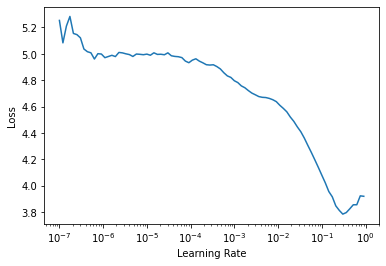

In [25]:
# learn2.lr_find()

In [45]:
use_mixup = False
model_fname = "/content/drive/MyDrive/imagewang_tests_soft_pseudolabels/model_psuedo_01"
cbs = [
    ReduceLROnPlateau(monitor='pseudolabel_accuracy', factor=5, patience=5),
    EarlyStoppingCallback(monitor='pseudolabel_accuracy', min_delta=0.01, patience=7),
    SaveModelCallback(monitor="pseudolabel_accuracy", fname=model_fname)
]

In [46]:
lr = 0.01
pct_start = 0.3
n_epochs = 20
learn2.fit_flat_cos(n_epochs, lr=lr, pct_start=pct_start, cbs=cbs)

epoch,train_loss,valid_loss,pseudolabel_accuracy,time
0,0.704280,0.688847,0.339527,04:17
1,0.576423,0.198157,0.260626,04:18
2,0.482223,1.060037,0.419700,04:19
3,0.450540,1.059481,0.495291,04:20
4,0.418274,0.605023,0.463222,04:19
5,0.401618,1.424845,0.365742,04:20
6,0.395066,1.034475,0.544413,04:22
7,0.398671,0.853567,0.483838,04:22
8,0.376578,1.737112,0.485111,04:21
9,0.367128,1.343700,0.550522,04:18


Better model found at epoch 0 with pseudolabel_accuracy value: 0.33952659368515015.
Better model found at epoch 2 with pseudolabel_accuracy value: 0.41969966888427734.
Better model found at epoch 3 with pseudolabel_accuracy value: 0.49529141187667847.
Better model found at epoch 6 with pseudolabel_accuracy value: 0.5444133281707764.
Better model found at epoch 9 with pseudolabel_accuracy value: 0.5505217909812927.
Better model found at epoch 12 with pseudolabel_accuracy value: 0.5663018822669983.
Better model found at epoch 13 with pseudolabel_accuracy value: 0.569610595703125.
Better model found at epoch 15 with pseudolabel_accuracy value: 0.5945532917976379.


# Further fine-tune on just training data

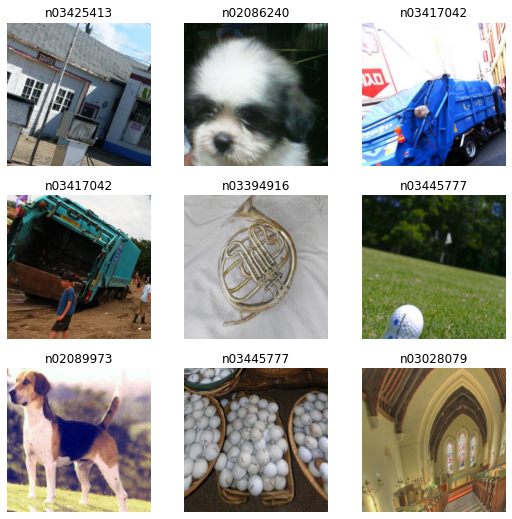

In [47]:
df_labelled = pd.concat([df_train, df_val])
dl_labelled = ImageDataLoaders.from_df(df=df_labelled, path = "/", fn_col="fname", label_col="class", valid_col="is_valid", batch_tfms=batch_tfms, item_tfms=item_tfms, bs=64)
dl_labelled.show_batch()

In [48]:
learn3 = cnn_learner(dl_labelled, 
                    partial(get_model, model=xresnet18, pretrained=False),
                    metrics=accuracy,
                    loss_func=LabelSmoothingCrossEntropy(), 
                    opt_func=opt_func).to_fp16()

learn3.load(model_fname)
learn3.unfreeze()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


SuggestedLRs(lr_min=0.012022644281387329, lr_steep=0.02754228748381138)

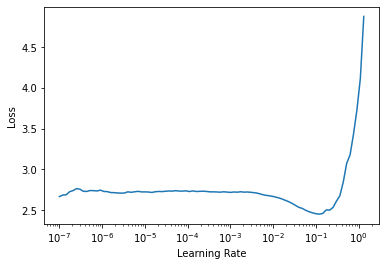

In [31]:
# learn3.lr_find()

In [49]:
use_mixup = False
model_fname3 = "/content/drive/MyDrive/imagewang_tests_soft_pseudolabels/model_psuedo_01_stage2"

cbs = [
    ReduceLROnPlateau(monitor='accuracy',factor=5,patience=5),
    EarlyStoppingCallback(monitor='accuracy', min_delta=0.01, patience=7),
    SaveModelCallback(monitor="accuracy", fname=model_fname3)
]
if use_mixup:
    cbs.append(MixUp(0.4))
print(cbs)

[ReduceLROnPlateau, EarlyStoppingCallback, SaveModelCallback]


In [50]:
lr = 3e-3
pct_start = 0.3
n_epochs = 20
learn3.fit_flat_cos(n_epochs, lr=lr, pct_start=pct_start, cbs=cbs)

epoch,train_loss,valid_loss,accuracy,time
0,1.204071,1.696012,0.600916,03:02
1,1.121151,1.668049,0.599644,03:03
2,1.076105,1.635237,0.615678,03:01
3,1.048270,1.697401,0.595826,03:02
4,1.026096,1.604340,0.630186,03:02
5,1.012992,1.631681,0.617460,03:02
6,0.972569,1.691739,0.595062,03:02
7,0.958809,1.662417,0.609061,03:03
8,0.959421,1.541479,0.656910,03:04
9,0.935145,1.544759,0.641894,03:04


Better model found at epoch 0 with accuracy value: 0.6009162664413452.
Better model found at epoch 2 with accuracy value: 0.6156783103942871.
Better model found at epoch 4 with accuracy value: 0.6301857829093933.
Better model found at epoch 8 with accuracy value: 0.6569101810455322.
Better model found at epoch 10 with accuracy value: 0.6586917638778687.
Better model found at epoch 11 with accuracy value: 0.6660727858543396.
Better model found at epoch 12 with accuracy value: 0.6724357604980469.
Better model found at epoch 13 with accuracy value: 0.682361900806427.
Better model found at epoch 14 with accuracy value: 0.6851615905761719.
Better model found at epoch 15 with accuracy value: 0.6966149210929871.
Better model found at epoch 16 with accuracy value: 0.7024688124656677.
Better model found at epoch 17 with accuracy value: 0.7083227038383484.


#predict pseudo-labels again and save

In [1]:
test_imgs = get_image_files(f"{path}/unsup")
dl_test = learn3.dls.test_dl(test_imgs)

NameError: ignored

In [ ]:
# def noop(x):
#     return x

In [ ]:
res = learn3.get_preds(dl=dl_test, with_decoded=True, act=noop)

In [ ]:
pred_proba = res[0].cpu().numpy()
pred_proba

In [ ]:
i2o = {v:k for k,v in dl.vocab.o2i.items()}
classes = [v for k,v in i2o.items()]
df_pred_probas = pd.DataFrame(pred_proba, columns=classes)
df_pred_probas.head(5)

In [ ]:
test_img_files = [str(f) for f in test_imgs]
df_unlabelled_images = pd.DataFrame({"fname": test_img_files})
df_pseudo_labels = pd.concat([df_unlabelled_images, df_pred_probas], axis=1)
df_pseudo_labels["is_valid"] = False
df_pseudo_labels.head(5)

In [ ]:
df_pseudo_labels.to_csv("/content/drive/MyDrive/imagewang_tests_soft_pseudolabels/pseudolabels_02.csv", index=False)